**RERE variants**

[Jordan et al (2018)](https://pubmed.ncbi.nlm.nih.gov/29330883) found that 
the total number of structural defects of the brain, eye, heart, 
and kidney and sensorineural hearing loss seen in individuals with point mutations 
in the Atrophin-1 domain of the RERE gene is significantly higher 
than expected based on the number of similar defects seen in individuals with putative loss-of-function variants.

Here we analyze the Phenopacket store *RERE* cohort to replicate the results. 

We use with counting phenotype predicate to count the number of phenotypic structural defects 
and we build genotype predicate to compare point mutations vs. LoF variants.

# Configure analysis

We will use HPO released on July 1st, 2024.

In [1]:
import hpotk

store = hpotk.configure_ontology_store()
hpo = store.load_minimal_hpo(release='v2024-07-01')
hpo.version

'2024-07-01'

This is how we will preprocess the cohort.

In [2]:
from genophenocorr.preprocessing import configure_caching_cohort_creator

cohort_creator = configure_caching_cohort_creator(hpo)

# Load phenopacket cohort

Let's load the individuals of Phenopacket store's *RERE* cohort:

In [3]:
from genophenocorr.preprocessing import load_phenopacket_folder

fpath_rere_cohort_dir = '/home/ielis/data/phenopacket-store/0.1.18/RERE'

cohort = load_phenopacket_folder(
    pp_directory=fpath_rere_cohort_dir,
    cohort_creator=cohort_creator,
    validation_policy='lenient',
)

Patients Created: 100%|██████████| 19/19 [00:01<00:00, 14.27it/s]
Validated under lenient policy
No errors or warnings were found
19 phenopacket(s) found at `/home/ielis/data/phenopacket-store/0.1.18/RERE`


# Setup predicates

## Phenotype predicate

In [4]:
from genophenocorr.analysis.predicate.phenotype import CountingPhenotypePredicate

structural_defects = (
    'HP:0012443',  # Abnormal brain morphology (Brain anomalies)
    'HP:0012372',  # Abnormal eye morphology (Eye anomalies)
    'HP:0001627',  # Abnormal heart morphology (Congenital heart defects)
    'HP:0012210',  # Abnormal renal morphology (Renal anomalies)
    'HP:0000407',  # Sensorineural hearing impairment (Sensorineural hearing loss)
)

ph_predicate = CountingPhenotypePredicate.from_query_curies(
    hpo=hpo,
    query=structural_defects,
)

## Genotype predicate

We will use the transcript accession selected by MANE consortium:

In [5]:
# MANE transcript ID
tx_id = 'NM_001042681.2'

Build the "Point mutation variant predicate".

We can either just take the missense variants or we can cast a broader net, by including other non-LoF variant effects, while ensuring that the net gain/loss is 0:

In [6]:
from genophenocorr.model import VariantEffect
from genophenocorr.analysis.predicate.genotype import VariantPredicates

point_mutation_effects = (
    VariantEffect.MISSENSE_VARIANT,
    # TODO: Check if we should also include the effects below.
    # The listed effects can technically be point mutations, 
    # but the authors probably did not want to include them.
    # VariantEffect.SYNONYMOUS_VARIANT,
    # VariantEffect.SPLICE_DONOR_VARIANT,
    # VariantEffect.SPLICE_DONOR_5TH_BASE_VARIANT,
    # VariantEffect.SPLICE_DONOR_REGION_VARIANT,
    # VariantEffect.SPLICE_ACCEPTOR_VARIANT,
    # VariantEffect.SPLICE_POLYPYRIMIDINE_TRACT_VARIANT,
    # VariantEffect.SPLICE_REGION_VARIANT,
)
point_mutation = VariantPredicates.change_length('==', 0) \
    & VariantPredicates.ref_length('==', 1) \
    & VariantPredicates.any(VariantPredicates.variant_effect(effect=effect, tx_id=tx_id) for effect in point_mutation_effects)

point_mutation.get_question()

'((change length == 0 AND ref allele length == 1) AND MISSENSE_VARIANT on NM_001042681.2)'

Loss of function variant predicate:

In [7]:
lof_effects = (
    VariantEffect.TRANSCRIPT_ABLATION,
    VariantEffect.FRAMESHIFT_VARIANT,
    VariantEffect.START_LOST,
    VariantEffect.STOP_GAINED,
)

lof_mutation = VariantPredicates.any(VariantPredicates.variant_effect(eff, tx_id) for eff in lof_effects)
lof_mutation.get_question()

'(TRANSCRIPT_ABLATION on NM_001042681.2 OR FRAMESHIFT_VARIANT on NM_001042681.2 OR START_LOST on NM_001042681.2 OR STOP_GAINED on NM_001042681.2)'

Genotype predicate



In [8]:
from genophenocorr.analysis.predicate.genotype import grouping_predicate

gt_predicate = grouping_predicate(
    first=point_mutation,
    second=lof_mutation,
)
gt_predicate.get_question()

'first: ((change length == 0 AND ref allele length == 1) AND MISSENSE_VARIANT on NM_001042681.2), second: (TRANSCRIPT_ABLATION on NM_001042681.2 OR FRAMESHIFT_VARIANT on NM_001042681.2 OR START_LOST on NM_001042681.2 OR STOP_GAINED on NM_001042681.2)'

# Run analysis

Still somewhat manual..

In [9]:
from collections import defaultdict

counts = defaultdict(list)

for patient in cohort.all_patients:
    gt = gt_predicate.test(patient)
    ph = ph_predicate.test(patient)
    if gt is not None:
        counts[gt.category].append(ph.phenotype)
    else:
        print(f'Could not bin patient {patient.patient_id} into any genotype category!')

Could not bin patient Subject 8[PMID_29330883_Subject_8] into any genotype category!
Could not bin patient Subject 2[PMID_27087320_Subject_2] into any genotype category!
Could not bin patient Subject 7[PMID_29330883_Subject_7] into any genotype category!


We cannot process 3 subjects because they harbor the variant `NM_001042681.2:c.4313_4318dup` which is neither a point mutation nor a LoF.

```
"vcfRecord": {
    "genomeAssembly": "hg38",
    "chrom": "chr1",
    "pos": "8358216",
    "ref": "T",
    "alt": "TGGTGGA"
}
```


These are the counts of structural defects by the genotype group:

In [10]:
first, second = gt_predicate.get_categories()
point_mutation_group = counts[first]
lof_mutation_group = counts[second]

point_mutation_group, lof_mutation_group

([1, 4, 1, 4, 1, 2, 4, 1, 2, 2], [1, 0, 1, 1, 0, 1])

These are the test results:

In [11]:
import scipy.stats as stats

mw_result = stats.mannwhitneyu(
    x=point_mutation_group, 
    y=lof_mutation_group, 
    alternative = 'two-sided',
)

mw_result

MannwhitneyuResult(statistic=np.float64(52.0), pvalue=np.float64(0.012074957610483744))

We got a significant p value!

Let's plot the count of structural defects:

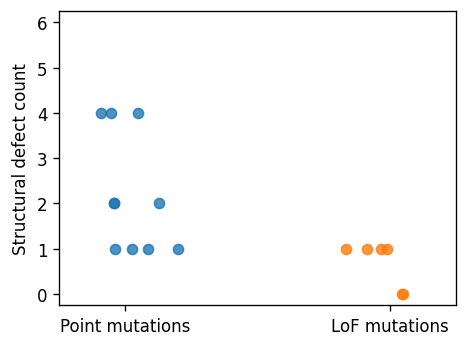

In [12]:
import matplotlib.pyplot as plt
import numpy as np


fig, ax = plt.subplots(figsize=(4, 3), dpi=120)

rng = np.random.RandomState(43)
# Point mutations
ax.plot(
    rng.normal(loc=0., scale=.1, size=(len(point_mutation_group),)), 
    point_mutation_group, 'o', 
    alpha=.8,
)
# LoF mutations
ax.plot(
    rng.normal(loc=1., scale=.1, size=(len(lof_mutation_group),)), 
    lof_mutation_group, 'o', 
    alpha=.8,
)
ax.set(
    xlim=(-.25, 1.25),
    ylabel='Structural defect count', ylim=(-.25, ph_predicate.n_categorizations() + .25),
)
ax.xaxis.set(ticks=(0, 1), ticklabels=['Point mutations', 'LoF mutations'])

fig.tight_layout()

*-* EOF *-*